In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_auc_score,confusion_matrix, f1_score,accuracy_score, classification_report
from sklearn.metrics import plot_roc_curve
import skimage
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **MODEL 1: Reload pretrain helmet detection**

As we have presented in the proposal, we use pretrain weights from ImageNetPretrained data with architecture of Faster RCNN + FPN
This model will serve as a predictor of helmet location in the image. The performance is acceptable at AP50 > 0.9.

More details on the evaluation of the model, please refer to the notebook `Run_Detectron_Helmet_detector`. 
Reference: https://www.kaggle.com/hieutrluu/run-detectron-helmet-detector

As a privacy of competition submission, we don't public share the notebook, please find the local file.

Output:
``` python
Accumulating evaluation results...
DONE (t=0.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.484
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
```


### **Installing Detectron locally**

Detectron2 is used as a main framework in this project for helmet detection.
As the complexity in installing via internet, we install locally linked with another notebook.

In [2]:
!python3 -m pip install ../input/nflimpactdetectron/detectron2/detectron2 --no-index --find-links ../input/nflimpactdetectron/wheelz/wheelz

Looking in links: ../input/nflimpactdetectron/wheelz/wheelz
Processing /kaggle/input/nflimpactdetectron/detectron2/detectron2
Processing /kaggle/input/nflimpactdetectron/wheelz/wheelz/fvcore-0.1.2-py3-none-any.whl
Processing /kaggle/input/nflimpactdetectron/wheelz/wheelz/pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl


  Created wheel for detectron2: filename=detectron2-0.3-cp37-cp37m-linux_x86_64.whl size=5563369 sha256=6af5704df4bfef01ae9c8143b54fc185f9bd1caded964ee20db474ed3ff72dfe
  Stored in directory: /tmp/pip-ephem-wheel-cache-uy47f6r4/wheels/a8/a2/bd/c673fab154eab56fe2c82c66f310d2a33bc4a1aaefaa8182e2
Successfully built detectron2


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode, Instances, Boxes


### **Model Configs**

To reload the pretrain model for helmet detection, we have to reconfig the parameters for the models.

In [4]:
def new_model_cfg():
    cfg = get_cfg()
    model = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
    cfg.merge_from_file(model_zoo.get_config_file(model))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
    cfg.MODEL.MASK_ON = False
    cfg.INPUT.RANDOM_FLIP = "none"
    cfg.OUTPUT_DIR = "output"
    cfg.DATASETS.TRAIN = ("nflimpact_train",)
    cfg.DATASETS.TEST = ("nflimpact_test",)

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.CHECKPOINT_PERIOD = 2000
    cfg.SOLVER.STEPS = (21000, 50000)
    cfg.SOLVER.MAX_ITER = 200000
    cfg.SOLVER.BASE_LR = 0.001
    cfg.TEST.EVAL_PERIOD = 2000
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
    cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True
    return cfg

In [5]:
# this sets up the pre-trained model with the weights from our dataset and creates a predictor off of it
classes = ["helmet"]
MetadataCatalog.get("nflimpact").set(thing_classes=classes)
cfg = new_model_cfg()
cfg.MODEL.WEIGHTS = "../input/nflimpactdetectron/model_v2_0071999.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

In [ ]:
# os.listdir('../input/extracting-frames-of-training-and-testing-videos/test')

### **Make images from video frames**

In [ ]:
"""
Run cropping on training data videos
"""
# !mkdir test
# import os
# for vid in os.listdir('../input/nfl-impact-detection/test'):
#     video_name = vid.split('.')[0]
    
#     vidcap = cv2.VideoCapture('../input/nfl-impact-detection/test/'+vid)
#     success,image = vidcap.read()
#     count = 1
#     while success:
#       cv2.imwrite("test/{}_frame{}.jpg".format(video_name,count), image)     # save frame as JPEG file      
#       success,image = vidcap.read()
#       count += 1

As the model detector is trained on the ground truth data, we will run test on a image frame from public test data of the competition.

The observed prediction is quite well, like what we got from predictor metrics.

/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


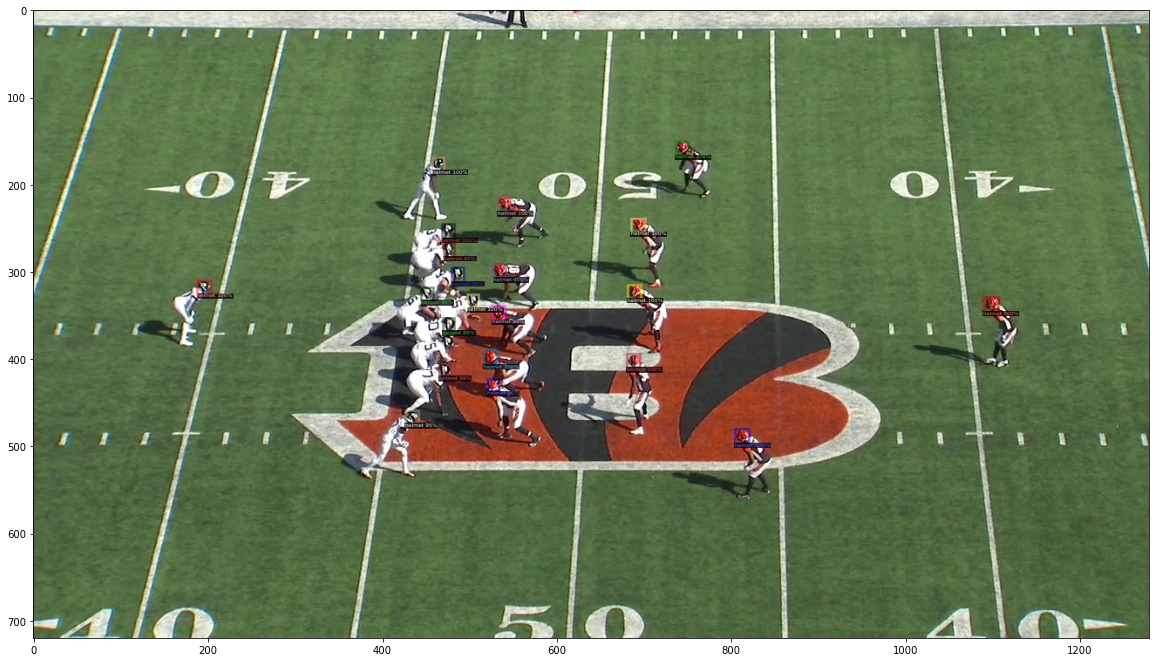

In [6]:
img = cv2.imread('../input/extracting-frames-of-training-and-testing-videos/test/57995_000109_Sideline_frame12.jpg')


# predict on the image
model_output = predictor(img)

model_output = model_output["instances"].to("cpu")
# only include detected instances with high enough score
ni = model_output[model_output.scores > 0.9]

# use the built-in visualizer to draw the boxes onto the image
v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("nflimpact"))
img = v.draw_instance_predictions(ni).get_image()
plt.figure(figsize = (20,20))
plt.imshow(img)
plt.show()

Untils functions to convert predictor bbox format to desired format.

In [ ]:
from detectron2.structures.boxes import  BoxMode
BoxMode.convert(model_output.pred_boxes.tensor.numpy(),BoxMode.XYXY_ABS ,BoxMode.XYWH_ABS)

# **Set-up submission dataset**

The following script will rearrange the output of Model 1 - helmet predictor.

Because the output of Model 1 is a bunch of bboxes for each image frame, then we should convert each of bbox as a single data point. Like what we have in `train_labels.csv`.

Please note that the output format of bbox in Model 1 is XYXY, what we want is XYWH for consistency. We have to use utils function to modify. 

The script for generating the output is commented out, for quick time running, we will reload the saved output.

In [ ]:
import sys

In [ ]:
"""
The follwing script is used to generate df_submission
We will import the generated data to save time
"""
# The following is the dataframe of predicted location of bbox where it is a helmet
# the result will be served for classifier model later
# df_submission = pd.DataFrame(columns=['gameKey','playID','view','video','frame','left','width','top','height','impact'])

# imgs_list = '../input/extracting-frames-of-training-and-testing-videos/test/'+ pd.Series(os.listdir('../input/extracting-frames-of-training-and-testing-videos/test'))
# imgs = [cv2.imread(img) for img in imgs_list]

# df_submission = pd.DataFrame(columns=['gameKey','playID','view','video','frame','left','width','top','height','impact','img_name'])

# _n = len(imgs_list)
# for idx, img in enumerate(imgs_list):
#     model_output = predictor(imgs[idx])
#     bbox_output = BoxMode.convert(model_output["instances"].to("cpu").pred_boxes.tensor.numpy(),BoxMode.XYXY_ABS ,BoxMode.XYWH_ABS)
#     video_name = img.split('/')[-1]
#     gameKey = int(video_name.split('_')[0])
#     playID = int(video_name.split('_')[1])
#     view = video_name.split('_')[2]
#     video = video_name.split('_frame')[0]
#     frame = int(video_name.split('_frame')[1].split('.')[0])
    
#     n = len(bbox_output)
    
#     _df = pd.DataFrame(columns=['gameKey','playID','view','video','frame','left','width','top','height','impact','img_name'])
#     _df['gameKey'] = pd.Series([gameKey]*n)
#     _df['playID'] = pd.Series([playID]*n)
#     _df['view'] = pd.Series([view]*n)
#     _df['video'] = pd.Series([video]*n)
#     _df['frame'] = pd.Series([frame]*n)
#     _df['img_name'] = pd.Series([video_name]*n)
    
#     _df['left'] = pd.Series(bbox_output[:,0])
#     _df['top'] = pd.Series(bbox_output[:,1])
#     _df['width'] = pd.Series(bbox_output[:,2])
#     _df['height'] = pd.Series(bbox_output[:,3])
    
#     df_submission = df_submission.append(_df)
    
#     sys.stdout.write("\rRow {}/2663".format(idx))
#     sys.stdout.flush()

# df_submission.to_csv('template_submission.csv')

In [ ]:
# Reload the saved dataset.
df_submission = pd.read_csv('../input/nlfimpactdfsubmission/template_submission.csv')
df_submission['video'] = df_submission['video'] + '.mp4'
del df_submission['Unnamed: 0']
df_submission.reset_index(inplace = True)
df_submission

# **MODEL 2: Classifier model**

### **Crop out sub-images**

As our approach is crop out the sub regions size (100x100) which center is the bbox of helmet, then we do binary classify problem on those data.

We have two notebook for crop out images:
* Training data: we split 20% for validation but named as test data. Please refer to Version 5: https://www.kaggle.com/hieutrluu/resnet18-on-bboxes
* Submission data: https://www.kaggle.com/ngockhanh5110/crop-for-submission

We have two approaches for processing data in cropping:
* Do Masking: we mask the bounding box values to 255. Our assumption is to make the model focus on the region around the masked area.
* No Masking: just keep the image after cropping out.

In [ ]:
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
try :
    import torchbearer
except :
    ! pip install torchbearer 
    import torchbearer 

In [ ]:
class MaxMask(object) :
    def __call__(self, image, bbox) :
        image_temp = image.clone()
        tl_x,tl_y,w,h = bbox
        br_x = tl_x + w
        br_y = tl_y + h
        image_temp[:,tl_y:br_y, tl_x:br_x] = 255
        return image_temp

In [ ]:
from tqdm import tqdm 
from PIL import Image
import matplotlib.pyplot as plt

class ImageDatasetBoxes(Dataset) :
    def __init__(self, crops=None, labels=None,frame=None, mask= True, size=50) :
        self.crops = crops
        self.labels = labels
        self.frame = None
        self.frame = frame
        self.frame.impact = self.frame.impact.fillna(0)
        self.frame.impactType = self.frame.impactType.fillna('None')
        self.toTensor = transforms.ToTensor()
        self.mask = MaxMask() if mask else None
        self.toPILImage = transforms.ToPILImage()
        self.size = size
        self.extractCropToTensor()
    
    def __len__(self) :
        if self.frame is not None :
            return len(self.frame)
        else :
            return len(self.crops)
    
    def extractCropToTensor(self) :
        dataset_len = self.__len__()
        self.crops = torch.zeros((dataset_len,3,self.size*2,self.size*2))
        self.labels = torch.zeros(dataset_len)

        k = 0
        for idx, row in self.frame.iterrows():
            print("Bbox {}/{}".format(idx,dataset_len))
            # get image path from dataframe
            path = '../input/extracting-frames-of-training-and-testing-videos/test/' + self.frame.img_name[idx]
#             folder = self.frame.video.to_numpy()[idx][:-4]
#             fr = self.frame.frame.to_numpy()[idx]
#             file = folder + '_' + str(fr + 1000)[1:] + '.png'
#             path += folder + '/' + file
            
            #read PIL Image from path
            pil_img = Image.open(path).convert('RGB')
            
            bbox = torch.Tensor(
                self.frame.loc[idx, ['left','top','width','height']]
            ).int()
            
            img = self.toTensor(pil_img)
            if self.mask is not None :
                img = self.mask(img, bbox)
            crop, shift = self.transformCrop(bbox)
            img_temp = img[:,crop[1]:crop[3],crop[0]:crop[2]]
            self.crops[k,:,shift[1]:,shift[0]:] = img_temp.clone()
            if (
                self.frame.impact[idx] == 1.0 
                and 
                self.frame.impactType[idx] == 'Helmet'
            ) :
                self.labels[idx] = 1
                
            k+=1
            
            
    def transformCrop(self, bbox):
        b = bbox.clone()
        m = b.clone()
        max_x = 720
        max_y = 1280
        center = (b[:2] + b[2:4] / 2).int()
        b[0] = center[0] - self.size
        b[1] = center[1] - self.size
        b[2] = center[0] + self.size
        b[3] = center[1] + self.size
        m[0] = 0 - min(b[0], 0)
        m[1] = 0 - min(b[1], 0)
        m[2] = max(b[2], max_y) - max_y
        m[3] = max(b[3], max_x) - max_x
        b[0] = b[0] if b[0] > 0 else 0
        b[1] = b[1] if b[1] > 0 else 0
        b[2] = b[2] if b[2] < max_y else max_y
        b[3] = b[3] if b[3] < max_x else max_x 
        return b, [max(m[0],m[2]), max(m[1],m[3])]
    
    def __getitem__(self, idx) :
        return self.crops[idx,:,:,:].squeeze(), self.labels[idx].long().squeeze()

In [ ]:
"""
It will mask the crop image for hidden test.
"""

# submission_imgs_mask = ImageDatasetBoxes(frame=df_submission)

In [7]:
# Load in no mask dataset
X_train = torch.load('../input/nfltrainimagecrop/train_ds_no_mask_crops.pt')
y_train = torch.load('../input/nfltrainimagecrop/train_ds_no_mask_labels.pt')
X_val = torch.load('../input/nfltrainimagecrop/test_ds_no_mask_crops.pt')
y_val = torch.load('../input/nfltrainimagecrop/test_ds_no_mask_labels.pt')

In [ ]:
# Load in masked dataset
X_train_mask = torch.load('../input/nfltrainimagecrop/train_ds_mask_crops.pt')
y_train_mask = torch.load('../input/nfltrainimagecrop/train_ds_mask_labels.pt')
X_val_mask = torch.load('../input/nfltrainimagecrop/test_ds_mask_crops.pt')
y_val_mask = torch.load('../input/nfltrainimagecrop/test_ds_mask_labels.pt')

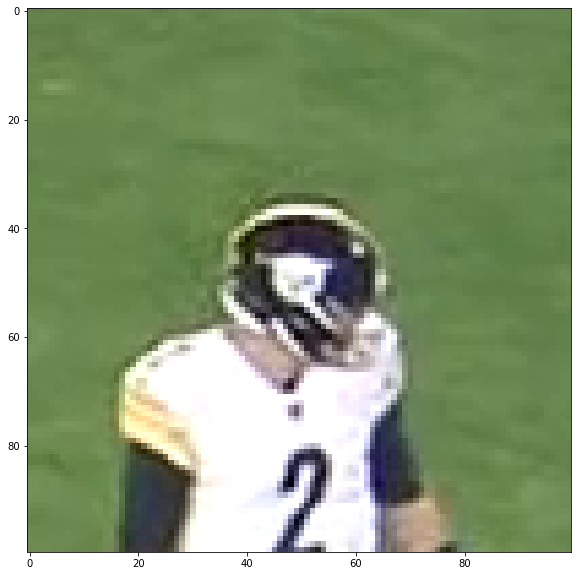

In [8]:
plt.figure(figsize = (10,10))
plt.imshow(X_train[300].permute(1,2,0), interpolation='nearest')

## **Using Basic ML Models: Classifier model**

### SVM model

Support vector machines are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis.

However, as we observed, the performance of SVM model is pretty bad.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
 
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
"""
Please uncomment the script for training model
Else: reload saved models
"""

# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.svm import SVC
# clf_svm = make_pipeline(RGB2GrayTransformer(),
#                         HogTransformer(
#                             pixels_per_cell=(8, 8),
#                             cells_per_block=(2,2),
#                             orientations=9,
#                             block_norm='L2-Hys'
#                         ),
#                         MinMaxScaler(),
#                         SVC(gamma='auto'))
# clf_svm.fit(X_train.permute(0,2,3,1), y_train)
# pickle.dump(clf_svm, open('BML_svm.m', 'wb'))

In [ ]:
_reload_model = pickle.load(open('../input/nlftrainedclassifier/BML_svm.m', 'rb'))
y_pred = _reload_model.predict(X_val.permute(0,2,3,1))

print(classification_report(y_val.numpy(),y_pred))

In [ ]:
"""
Please uncomment the script for training model
Else: reload saved models
"""

# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.svm import SVC
# clf_svm = make_pipeline(MinMaxScaler(),SVC(gamma=0.0001))
# clf_svm.fit(X_train_mask.reshape((X_train_mask.shape[0],-1)), y_train_mask)
# pickle.dump(clf_svm, open('BML_svm_mask.m', 'wb'))

In [ ]:
# _reload_model = pickle.load(open('BML_svm_mask.m', 'rb'))
# y_pred = _reload_model.predict(X_val_mask.reshape((X_val_mask.shape[0],-1)))

# print(classification_report(y_val_mask.numpy(),y_pred))

### Logistic Regression

In [ ]:
"""
Please uncomment the script for training model
Else: reload saved models
"""
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LogisticRegression
# clf_lg = make_pipeline(MinMaxScaler(),LogisticRegression())
# clf_lg.fit(X_train.reshape((X_train.shape[0],-1)), y_train)
# pickle.dump(clf_lg, open('BML_lg.m', 'wb'))

In [9]:
_reload_model = pickle.load(open('../input/nlftrainedclassifier/BML_lg.m', 'rb'))
y_pred = _reload_model.predict(X_val.reshape((X_val.shape[0],-1)))

print(classification_report(y_val.numpy(),y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.76      0.73       592
         1.0       0.47      0.39      0.43       325

    accuracy                           0.63       917
   macro avg       0.58      0.58      0.58       917
weighted avg       0.62      0.63      0.62       917



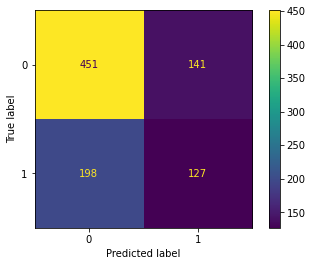

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_val.numpy(), y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

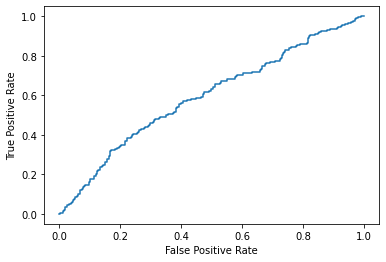

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
y_score = _reload_model.decision_function(X_val.reshape((X_val.shape[0],-1)))

fpr, tpr, _ = roc_curve(y_val.numpy(), y_score, pos_label=_reload_model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

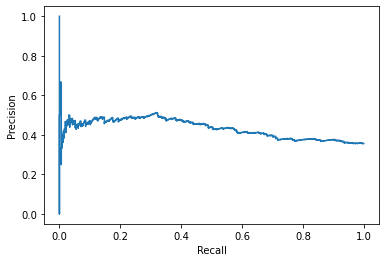

In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_val.numpy(), y_score,
                                         pos_label=_reload_model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

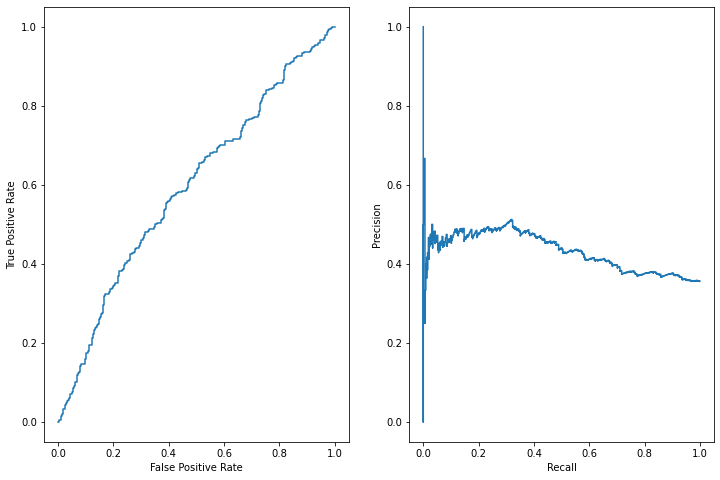

In [13]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

In [ ]:
"""
Please uncomment the script for training model
Else: reload saved models
"""

# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.svm import SVC
# clf_lg = make_pipeline(MinMaxScaler(),LogisticRegression())
# clf_lg.fit(X_train_mask.reshape((X_train_mask.shape[0],-1)), y_train_mask)
# pickle.dump(clf_lg, open('BML_lg_mask.m', 'wb'))

In [ ]:
_reload_model = pickle.load(open('../input/nlftrainedclassifier/BML_lg_mask.m', 'rb'))
y_pred = _reload_model.predict(X_val_mask.reshape((X_val_mask.shape[0],-1)))

print(classification_report(y_val_mask.numpy(),y_pred))

### SGDClassifer

In [ ]:
"""
Please uncomment the script for training model
Else: reload saved models
"""
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import SGDClassifier
# clf_sgd = make_pipeline(MinMaxScaler(),SGDClassifier())
# clf_sgd.fit(X_train.reshape((X_train.shape[0],-1)), y_train)
# pickle.dump(clf_sgd, open('BML_sgd.m', 'wb'))

In [14]:
_reload_model = pickle.load(open('../input/nlftrainedclassifier/BML_sgd.m', 'rb'))
y_pred = _reload_model.predict(X_val.reshape((X_val.shape[0],-1)))

print(classification_report(y_val.numpy(),y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.59      0.65       592
         1.0       0.45      0.61      0.52       325

    accuracy                           0.60       917
   macro avg       0.59      0.60      0.59       917
weighted avg       0.63      0.60      0.61       917



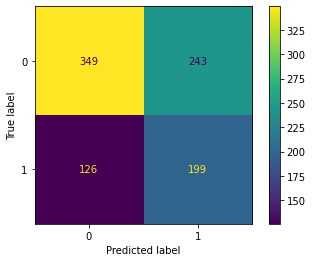

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_val.numpy(), y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

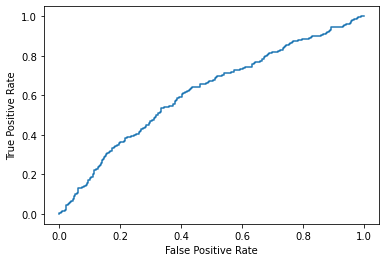

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
y_score = _reload_model.decision_function(X_val.reshape((X_val.shape[0],-1)))

fpr, tpr, _ = roc_curve(y_val.numpy(), y_score, pos_label=_reload_model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

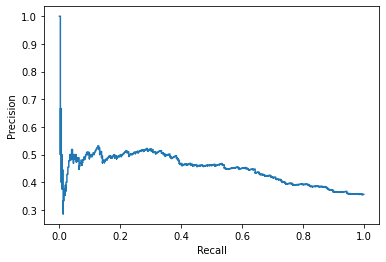

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_val.numpy(), y_score,
                                         pos_label=_reload_model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

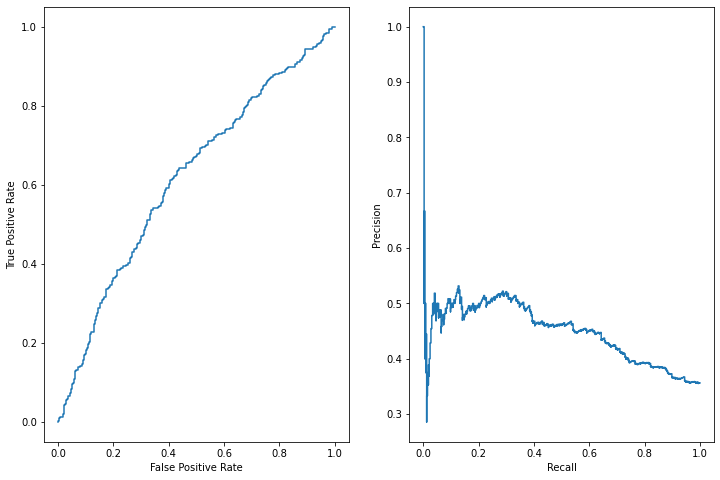

In [18]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

In [ ]:
"""
Please uncomment the script for training model
Else: reload saved models
"""
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import SGDClassifier
# clf_sgd = make_pipeline(MinMaxScaler(),SGDClassifier())
# clf_sgd.fit(X_train_mask.reshape((X_train_mask.shape[0],-1)), y_train_mask)
# pickle.dump(clf_sgd, open('BML_sgd_mask.m', 'wb'))

In [ ]:
# _reload_model = pickle.load(open('BML_sgd_mask.m', 'rb'))
# y_pred = _reload_model.predict(X_val.reshape((X_val.shape[0],-1)))

# print(classification_report(y_val.numpy(),y_pred))

In [ ]:
_reload_model = pickle.load(open('../input/nlftrainedclassifier/BML_sgd.m', 'rb'))

### **Artificial Neural Network (ANN)**

Please refer to `nn-for-submission`.

# **Adjust dataframe for submission**

In [ ]:
# The data will be loaded differently in submission.


_data = torch.load('../input/crop-for-submission/submission_imgs_no_mask_crops_0.pt')
pred = _reload_model.predict(_data.reshape((_data.shape[0],-1)))
df_submission.loc[:10000-1,'impact'] = pd.Series(pred, index=df_submission.loc[:10000-1,'index'])

_data = torch.load('../input/crop-for-submission/submission_imgs_no_mask_crops_1.pt')
pred = _reload_model.predict(_data.reshape((_data.shape[0],-1)))
df_submission.loc[10000:20000-1,'impact'] = pd.Series(pred, index=df_submission.loc[10000:20000-1,'index'])

_data = torch.load('../input/crop-for-submission/submission_imgs_no_mask_crops_2.pt')
pred = _reload_model.predict(_data.reshape((_data.shape[0],-1)))
df_submission.loc[20000:30000-1,'impact'] = pd.Series(pred, index=df_submission.loc[20000:30000-1,'index'])

_data = torch.load('../input/crop-for-submission/submission_imgs_no_mask_crops_3.pt')
pred = _reload_model.predict(_data.reshape((_data.shape[0],-1)))
df_submission.loc[30000:40000-1,'impact'] = pd.Series(pred, index=df_submission.loc[30000:40000-1,'index'])

_data = torch.load('../input/crop-for-submission/submission_imgs_no_mask_crops_4.pt')
pred = _reload_model.predict(_data.reshape((_data.shape[0],-1)))
df_submission.loc[40000:50000-1,'impact'] = pd.Series(pred, index=df_submission.loc[40000:50000-1,'index'])

_data = torch.load('../input/crop-for-submission/submission_imgs_no_mask_crops_5.pt')
pred = _reload_model.predict(_data.reshape((_data.shape[0],-1)))
df_submission.loc[50000:,'impact'] = pd.Series(pred, index=df_submission.loc[50000:,'index'])

In [ ]:
df_submission
df_submission.to_csv()

In [ ]:
df_submission_impact = df_submission.loc[df_submission['impact']==1,['gameKey','playID','view','video','frame','left','width','top','height']]
df_submission_impact['left'] =df_submission_impact['left'].astype(int)
df_submission_impact['width'] =df_submission_impact['width'].astype(int)
df_submission_impact['top'] =df_submission_impact['top'].astype(int)
df_submission_impact['height'] =df_submission_impact['height'].astype(int)
df_submission_impact.reset_index(inplace=True, drop=True)
df_submission_impact.to_csv()

df_submission_impact

In [ ]:
import nflimpact
env = nflimpact.make_env()
env.predict(df_submission_impact) # df is a pandas dataframe of your entire submission file